In [1]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import get_linear_schedule_with_warmup
import numpy as np

In [2]:
import pandas as pd
import re

In [3]:
# loading pre-trained models
from transformers import (
    BertForSequenceClassification,
                          BertTokenizer,
                          RobertaForSequenceClassification,
                          RobertaTokenizer,
                         AdamW)

In [4]:
# Target labels
label_encodings3 = {
    'pants-fire': 0, 
    'false':      0, 
    'barely-true':1, 
    'half-true':  1, 
    'mostly-true':2,
    'true':       2
}
label_encodings6 = {
    'pants-fire': 0, 
    'false':      1, 
    'barely-true':2, 
    'half-true':  3, 
    'mostly-true':4,
    'true':       5
}

In [5]:
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset
        



In [23]:
# Device
device = torch.device("cpu")

# BERT
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
                                                           num_labels = 6, # The number of output labels--2 for binary classification.
                                                                           # You can increase this for multi-class tasks.
                                                           output_attentions = False, # Whether the model returns attentions weights.
                                                           output_hidden_states = False # Whether the model returns all hidden-states.
                                                          )
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [24]:
# Read in data

df_train = pd.read_csv("Data/liar_dataset/train.csv")
df_test = pd.read_csv("Data/liar_dataset/test.csv")
df_valid = pd.read_csv("Data/liar_dataset/valid.csv")

# df_train = pd.read_csv("Data/liar_dataset/aug/train_aug.tsv", sep='\t', header=None).drop(0, axis=1)
# df_test = pd.read_csv("Data/liar_dataset/aug/test_aug.tsv", sep='\t', header=None).drop(0, axis=1)
# df_valid = pd.read_csv("Data/liar_dataset/aug/valid_aug.tsv", sep='\t', header=None).drop(0, axis=1)

# # Relabel columns
# cols = ['ID', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state',
#        'party', 'barely_true_count', 'false_count', 'half_true_count',
#        'mostly_true_count', 'pants_on_fire_count', 'context']

# df_train.columns = cols
# df_test.columns = cols
# df_valid.columns = cols

In [25]:
# Relabel
df_train['target'] = df_train['label'].apply(lambda x: label_encodings6[x])
df_test['target'] = df_test['label'].apply(lambda x: label_encodings6[x])
df_valid['target'] = df_valid['label'].apply(lambda x: label_encodings6[x])

# Generate indexed tokens per statement
bert_input_ids = []
bert_attention_masks = []

for sent in df_train['statement']:
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    
# Convert the lists into tensors.
bert_input_ids = torch.cat(bert_input_ids, dim=0)
bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

# Get targets
labels = torch.tensor(df_train['target'])
sentence_ids = torch.tensor(range(df_train.shape[0]))

# function to seed the script globally
torch.manual_seed(0)

# Combine the training inputs into a TensorDataset.
bert_dataset = TensorDataset(sentence_ids, bert_input_ids, bert_attention_masks, labels)

# Remove indices
trial_dataset =  index_remover(bert_dataset)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [26]:
# Train/Test Split

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(bert_dataset))
val_size = len(bert_dataset) - train_size

# Divide the dataset by randomly selecting samples.
bert_train_dataset, bert_val_dataset = random_split(bert_dataset, [train_size, val_size])

# removing sentence ids from tensor dataset so that it can be used for training 
bert_train_dataset = index_remover(bert_train_dataset)
bert_val_dataset = index_remover(bert_val_dataset)


In [27]:
# Dataloader
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [28]:
# Optimizer
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Epochs & Learning Rate
epochs = 2
total_steps = len(bert_train_dataloader) * epochs

# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [29]:
import time
import datetime
import random

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [30]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
bert_training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the bert_model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-bert_model-train-do-in-pytorch)
    bert_model.train()

    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

        # Unpack batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Zero grads
        bert_model.zero_grad()        

        # Forward pass
        output = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        # Accumulate loss
        total_train_loss += output[0].item()

        # Backward pass
        output[0].backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The bert_optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        bert_optimizer.step()

        # Update the learning rate.
        bert_scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(bert_train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the bert_model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = bert_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        total_eval_loss += outputs[0].item()

        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(bert_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(bert_validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    bert_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 2 ========
Training...
  Batch    40  of    288.    Elapsed: 0:05:39.
  Batch    80  of    288.    Elapsed: 0:11:16.
  Batch   120  of    288.    Elapsed: 0:16:50.
  Batch   160  of    288.    Elapsed: 0:22:36.
  Batch   200  of    288.    Elapsed: 0:28:11.
  Batch   240  of    288.    Elapsed: 0:33:52.
  Batch   280  of    288.    Elapsed: 0:39:43.

  Average training loss: 1.73
  Training epcoh took: 0:41:06

Running Validation...
  Accuracy: 0.29
  Validation Loss: 1.67
  Validation took: 0:01:42
======== Epoch 2 / 2 ========
Training...
  Batch    40  of    288.    Elapsed: 0:06:52.
  Batch    80  of    288.    Elapsed: 0:13:45.
  Batch   120  of    288.    Elapsed: 0:20:36.
  Batch   160  of    288.    Elapsed: 0:27:27.
  Batch   200  of    288.    Elapsed: 0:34:18.
  Batch   240  of    288.    Elapsed: 0:41:21.
  Batch   280  of    288.    Elapsed: 0:47:52.

  Average training loss: 1.58
  Training epcoh took: 0:49:00

Running Validation...
  Accuracy: 0.28
  V

### Validation & Reporting Accuracy

In [31]:
# Encode the test set
bert_input_ids_test = []
bert_attention_masks_test = []

for sent in df_test['statement']:
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )
    bert_input_ids_test.append(bert_encoded_dict['input_ids'])
    bert_attention_masks_test.append(bert_encoded_dict['attention_mask'])
    
# Convert the lists into tensors.
bert_input_ids_test = torch.cat(bert_input_ids_test, dim=0)
bert_attention_masks_test = torch.cat(bert_attention_masks_test, dim=0)

# Get labels
bert_labels_test = torch.tensor(df_test['target'])

In [32]:
# Encode the validation set
bert_input_ids_valid = []
bert_attention_masks_valid = []

for sent in df_valid['statement']:
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )
    bert_input_ids_valid.append(bert_encoded_dict['input_ids'])
    bert_attention_masks_valid.append(bert_encoded_dict['attention_mask'])
    
# Convert the lists into tensors.
bert_input_ids_valid = torch.cat(bert_input_ids_valid, dim=0)
bert_attention_masks_valid = torch.cat(bert_attention_masks_valid, dim=0)

# Get labels
bert_labels_valid = torch.tensor(df_valid['target'])

In [33]:
# Run the inputs through the model
with torch.no_grad():
    outputs_test = bert_model(bert_input_ids_test,
                              token_type_ids=None, 
                              attention_mask=bert_attention_masks_test,
                              labels=bert_labels_test)
    outputs_valid = bert_model(bert_input_ids_valid,
                               token_type_ids=None, 
                               attention_mask=bert_attention_masks_valid,
                               labels=bert_labels_valid)

In [34]:
# Augmented Dataset, Test & Validation Reporting Functions
def get_first_idx(lst):
    latest_idx = [0]
    latest = lst[0]
    for i in range(1,len(lst)):
        if lst[i]!=latest:
            latest_idx.append(i)
            latest = lst[i]
    return latest_idx

In [35]:
np.mean([a==b for a,b in zip(np.argmax(outputs_test[1].detach().cpu().numpy()[get_first_idx(df_test['ID'])], axis=1), 
                             bert_labels_test.detach().numpy()[get_first_idx(df_test['ID'])])])

0.2833464877663773

In [36]:
np.mean([a==b for a,b in zip(np.argmax(outputs_valid[1].detach().cpu().numpy()[get_first_idx(df_valid['ID'])], axis=1), 
                             bert_labels_valid.detach().numpy()[get_first_idx(df_valid['ID'])])])

0.26713395638629284

[[ 22  23   7   4   2   3]
 [ 46  76  40  39  32  15]
 [  8  27  30  24  17   6]
 [ 27  74 101 111  78  53]
 [  5  32  41  43  67  55]
 [  8  31  18  27  55  37]]


<AxesSubplot:>

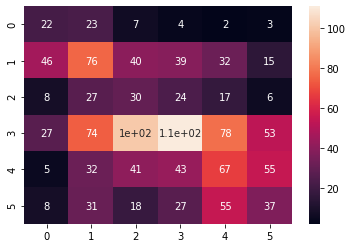

In [37]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(np.argmax(outputs_valid[1].detach().cpu().numpy(), axis=1), 
                             bert_labels_valid.detach().numpy())
print(cf_matrix)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [38]:
import pickle
with open('huggingface_bert_model6.data', 'wb') as filehandle:
    pickle.dump(bert_training_stats, filehandle)
    
torch.save(bert_model.state_dict(), "huggingface_bert6.pt")